## <center> Smart Beta Momentum Strategy using Quantopian </center>

### Smart Beta Overview

Smart Beta is a combination of traditional active management with passive investing. The goal is construct portfolios that take advantage of investment strategies that lead to optimal returns and expense relative to traditional market-cap based indices. Ideally, smart beta strategies are transparent, understandable, and rules-based. Furthermore, the rules-based nature of Smart Beta strategies typically leads to algorithmic strategies.

### Momentum Factor

Smart Beta strategies commonly focus on factor-based model weightings such as volatility, liquidity, quality, value, size and momentum. Momentum strategies post recession have been of strong demand given the strength in what traditional investors would call 'growth stocks' such as technology stocks (i.e. GOOG, AMZN, FB) in recent years. The general idea of momentum is the view that certain stocks in uptrends will continue rising, while stocks going down can continue to fall. ETFs like MUTM, PDP, ONEO have surged in popularity and implement various factor-based momentum strategies


### Why Quantopian?

Quantopian is an open-sourced web-based platform where members can develop, back-test, and share algorithmic stock trading strategies. It's main benefit is it's community where members can ask for help, share ideas, discuss code, and share data. On top of this has tons of free data plus an easy-to-use backtester where as traditionally building a custom backtester (without errors) takes months if not years if working alone.


In [ ]:
from quantopian.algorithm import attach_pipeline, pipeline_output
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import AverageDollarVolume
from quantopian.pipeline.filters.morningstar import Q500US #Top 500 stocks by market cap
 
import numpy as np
from scipy import stats

The **calc_slope( )** is main function of the algorithm. Essentially for each stock we calculate the regression for the given time window (see below/set to 90 days). The slope tells the percentage change in the regression line over the period so a slope of 1.05 means the line moved up to 5% per day. Note we annualize this value using 250 trading days. Our **momentum factor** is the regression slope * $corr$_$coeffiecent^{2}$ (r_value) 

In [ ]:
def calc_slope(ts):
    x = np.arange(len(ts))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, ts)
    annualized_slope = (np.power(np.exp(slope), 250) -1) *100
    return annualized_slope * (r_value ** 2) 

**initialize()** is a standard Quantopian function that is called at the beginning of the algorithm during the back-testing phases. Here we call our our dependement functions. The _momentum_ _window_ is the look back period for the regression slope. The _minimum_ _momentum_ is an arbitrarily set number (will discuss pro / cons below) is the min slope to include a stop. _Number of stocks_ is arbitrary but again limits number of stocks in portfolio.

In [ ]:
 def initialize(context): 
    # Setting global parameters
    context.momentum_window = 90
    context.minimum_momentum = 30
    context.number_of_stocks = 100
    
    # Set rebalacing to monthly
    schedule_function(rebalance, date_rules.month_start(), time_rules.market_open(hours=1))
     
    # Create our dynamic stock selector.
    attach_pipeline(make_pipeline(), 'us_500')

**make_pipeline( )** - here we set out stock search universe. Chose 500 US Stocks which correlates with S&P500 benchmark but can easily expand. We run our screener on the prior days close prices. This returns a dataframe which the back tester uses to aggregate portfolio information. 

In [ ]:
def make_pipeline():
    # Base universe set to the Q500US
    base_universe = Q500US()
    yesterday_close = USEquityPricing.close.latest
     
    pipe = Pipeline(
        screen = base_universe,
        columns = {
            'close': yesterday_close,
        }
    )
    return pipe 
 

**rebalance( )** contains the trading rules and portfolio rebalancing logic. Essentially at the end of each month we run our algorithm and compute the regression slopes for each stock in the 'universe' ie top 500 mrkt cap. We then sort the these values from largest to smallest choosing the top _number of stocks_ (= 100). For these 100 we check if our current portfolio stocks are within these 100 ranked stocks. We then have 3 rules:
 - If stock not in top ranked list: sell stock from current portfolio 
 - If stock in buy list but momentum factor < minimum momentum factor (i.e. 30): set weight to 0 i.e. no order
 - If stock in buy list: buy $\frac{1}{\#stocks}$ weighting

In [ ]:
def rebalance(context,data):
    # update the current top 500 us stocks
    context.output = pipeline_output('us_500') 
    context.security_list = context.output.index
    
    momentum_list = np.log(data.history(context.security_list, "close", context.momentum_window, "1d")).apply(calc_slope)
    
    ranking_table = momentum_list.sort_values(ascending=False) # Sorted
    
    buy_list = ranking_table[:context.number_of_stocks] # These we want to buy
    
    # Trading rules 
    for security in context.portfolio.positions:
        # Sells stock from portfolio if not in buy list
        if security not in buy_list:
            order_target(security, 0.) 
  
    for security in context.security_list:
        if security in buy_list:
            if buy_list[security] < context.minimum_momentum:
                weight = 0.
            else:
                # Weight each stock uniformly - can do more informative ways
                weight = 1.0 / context.number_of_stocks
            # weight = 0 tells the algorithm to sell 
            order_target_percent(security, weight) 
            
            

## Analysis & Discussion

Note the above code was run in Quantian's web environment. Mainly because I'm more familiar with it and secondly I haven't configured running locally via zipline or alphalens. Below we analyze **a few** interesting standard performance results displayed by Quantopian and discuss the **Pros / Cons** of the strategy vs our **S&P500 Benchmark**

In [1]:
from IPython.display import Image

#### Results Overview 3/2013-3/2018

The below plot shows the total returns, beta, sharpe, max drawdown etc for the portfolio. We see that portfolio returns tracked SPY up until 2016 before lagging the benchmark for all of 2016-2018. 

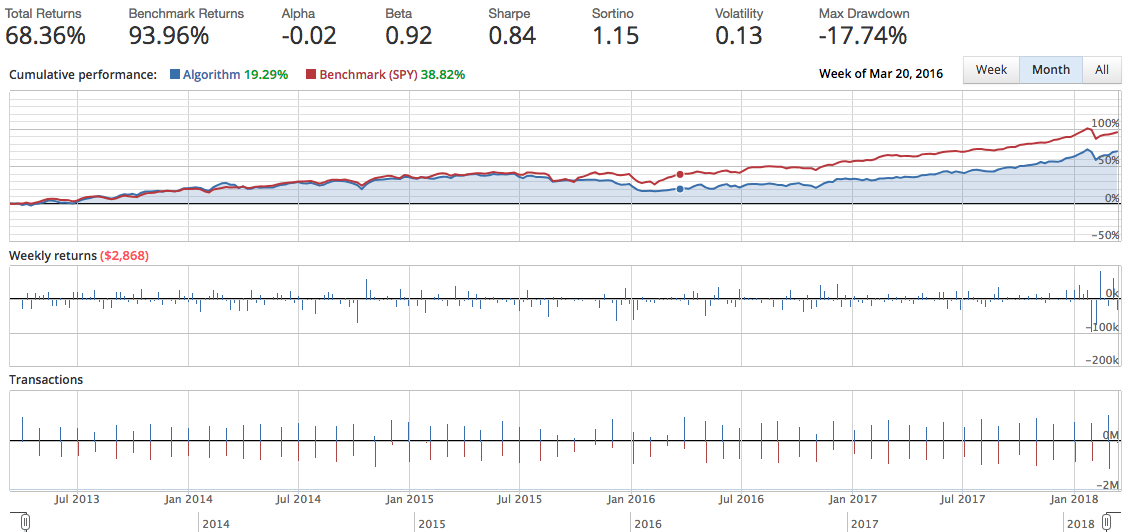

In [5]:
Image("smart_beta_data/overall_returns.png", width=1000, height=1000)

#### Strategy Attribution: Fama-French Factor Betas

Fundamental factor models are discussing in the introduction. One way in which we can use factors is to build a linear factor model. Given a set of  k  fundamental factors, we can represent the returns of an asset,  **$R_{t}$** , as follows:

<center>$R_{t}=\alpha_t+\beta_{t,F_{1}}F_{1}+\beta_{t,F_{2}}F_{2}+...+\beta_{t,F_{k}}F_{k}+ϵ_{t}$</center>
 
where each  $F_{j}$  represents a factor return. One of the most well-known examples of this approach is the Fama-French factor model that uses market cap, book-to-price ratio, and momentum as a model. 

A super cool plot from Quantopian is the Fama-French factor attribution plot below which shows how your model's attribition is attributed. Interestingly enough, we see that in late 2015 to early 2017 the momentum factor beta deteoriates to negative values while 'growth' and 'SMB' increase. This is interesting since it coincides with the preformance of the momentum strategy 

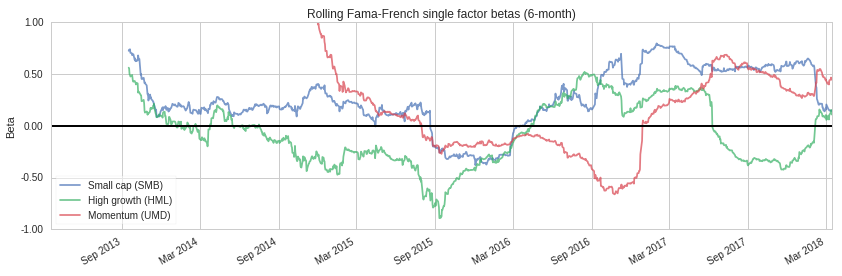

In [7]:
Image("smart_beta_data/fama_french_factors.png", width=1000, height=500)

#### Diversification (Con?)

What does this strategy really give me? What's my exposure too? A common problem with naive factor models is there tendancy to overweight industries, sectors, individual stocks as a consequence of sexy backtest results. Below is a graph of the top historical holdings by percentage. We see that in 2014 stock ticker OAS, a petroleum company was the biggest holding at 2%; in 2017 SPRT a biotechnology firm. Overall in 2016 10 stocks accounted for ~20% of our portfolio holdings. 

**Diversification** in SPY is a major pro vs factor based models that tend to concentrate risk into a few names. Mean-variance theory explores that trade off of expected return vs portfolio variance. Additionally with SPY we can look at the sectors/industry weights i.e. we know what we're getting. With this the weightings change dynamically each month with no limit on sector/industry concentration.

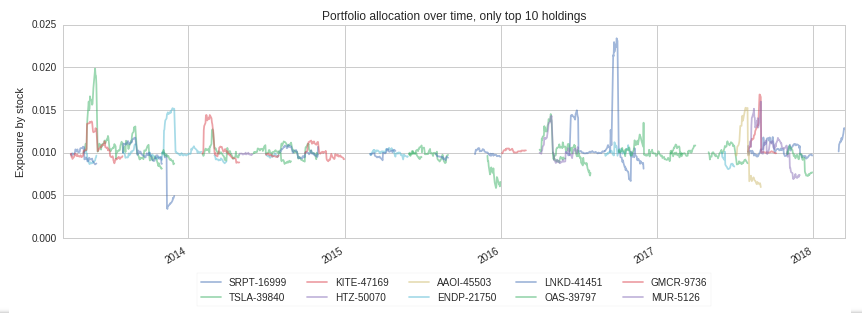

In [17]:
Image("smart_beta_data/top_stock_exposure.png", width=1000, height=1000)

#### Factor Returns: What am I return getting?

Below are two interesting charts that use Quantopian's 'style'factor model which is essentially the same as our model and based on Fama-French original model where using rolling regression factors they explain a strategy's performance. The first graph is easier to see but from late 2015 to early 2017 notice that the **size** and **volatility** factors where meaningfully negative (<2% and <6% respectively) while **momentum** was only positive 2%.

Furthermore, graph two shows how our momentum strategy's 'style' exposure factors change over time. It's harder to see but in 2015-2017 the **size (red)** factor was the largest, while **momentum expsoure (green)** decreased and **volatility** increased. This may be the main cause of the decoupling from SPY.

More broadly, this highlights con with the strategy vs SPY market-cap index in that we really momentum to be the main factor and while this has that exposure, size is in fact the largest factor.

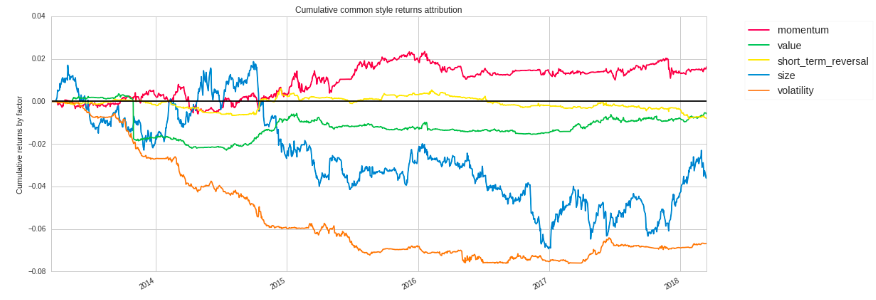

In [12]:
Image("smart_beta_data/style_factor_returns.png", width=1000, height=500)

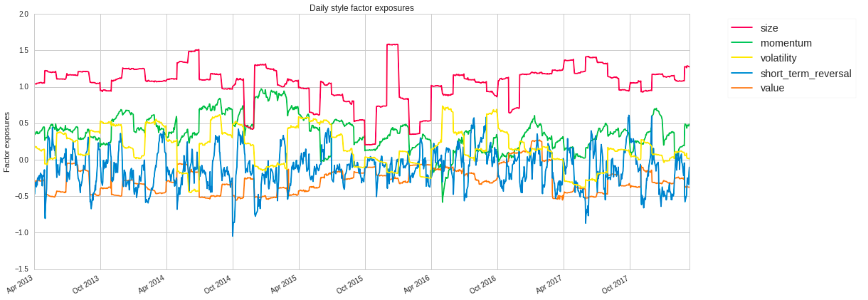

In [8]:
Image("smart_beta_data/style_factor_exposures.png", width=1000, height=500)

#### Thoughts on Expense & SPY Benchmark?

There's whole host of additional risk metrics we could discuss and compare vs our benchmark but we'll end with a few lines on the expense (ratio) vs our benchmark of the strategy. Buying SPY is fairly simple and cheap. As of 5/17/18 the expense ratio for SPY ETF was only 0.09% an. Given i'm very new to Quantopian calculating the expense ratio was bit more time intensive and I don't have an exact apples to apples comparisons. That said the **daily portfolio turnover** of this momentum strategy is **5.5%**.

For an individual investor (\$10k-\$100k) you'd want a scientific method to compare expense. Quantopian has default transaction costs and slippage factored in (still learning how to change), but you need to compare number of transactions * cost vs benchmark expense ratio. For high-net wealth (>\$1mm) and instutions (>\$10mm) economies of scale come into play reducing expense (one obvious benefit of ETFs). 

Moreover, the SPY benchmark may not be the best comparison for this strategy. Really want we want is to use the MTUM or PDP momentum ETFs above and compare this strategy to these benchmarks adjusting for things such as leverage, expense, diversification, drawdown, etc, etc. Hence while SPY is the 'easy' typical benchmark, in fact for momentum smart beta stratgies like this it's not an apples to apples comparison. 

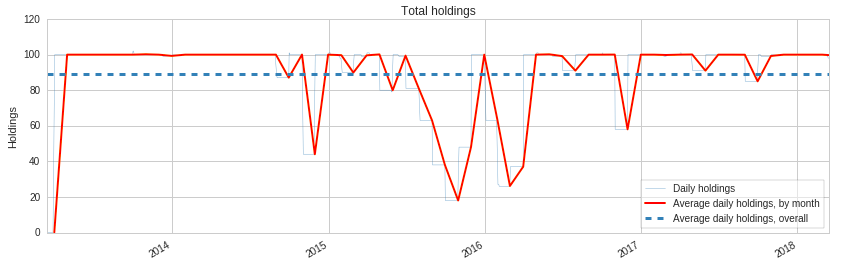

In [19]:
Image("analysis/avg_daily_holdings.png", width=1000, height=500)

_Acknowledgements_: 

[Andreas Clenow](https://www.quantopian.com/posts/equity-momentum) who implemented a robust implementation vs this scaled down momentum strategy.

[etfdb.com](http://etfdb.com/type/investment-style/high-momentum/) for example momentum ETF funds

[momentum discussion](https://www.investopedia.com/terms/s/smart-beta.asp) general smart beta notes

